In [1]:
require(cowplot)
require(data.table)
require(ggplot2)
require(pbapply)
pboptions(type="timer")

Loading required package: cowplot

Loading required package: data.table

Loading required package: ggplot2

Loading required package: pbapply



### Read input region metadata.

In [21]:
probe_meta = fread("data/rois/all_regions.tsv")
probe_summary = fread("data/probe_summary_probelet.tsv")    # data/probe_summary.csv
probelist = list.files("data/", recursive=TRUE, pattern="probe_.+oligos\\.tsv$")

current_region = 1

current_probe_id = 3    # 5 <-> 1e-5 etc
probe = fread(paste("data",probelist[current_probe_id],sep="/"))

probelist[current_probe_id]
head(probe)

[1] "query_output_20220328-161338/probe_roi_1.48oligos.tsv"

name,chromosome,start,end,sequence,gc_content,off_target_no,off_target_sum,Tm_dG,Tm_dH,Tm_dS,Tm,ss_dG,oligo_cost
<chr>,<chr>,<int>,<int>,<chr>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ROI_1,chr21,27878136,27878216,TTTTAATGCTTTTCGTAAGCGCGAGAGAAGAAATTGAGATAACGTTGCATTAAGGAACTATTTAGTCTTGGGAGATACAT,0.3500,1,141,-97.66306,-637.2,-1.7396,81.46896,-3.266,0.5997316
ROI_1,chr21,27878360,27878440,GACCACACCAACATATAGCATGCATCCGTCATCTCAATAGGCCCATTGTGCCCATTACAGTCAATCGACCACCCATTTCC,0.4875,1,139,-107.78280,-645.8,-1.7347,87.28927,-3.103,0.6078633
ROI_1,chr21,27878551,27878631,ATTAATTTTACTTTAATTCTAGGTCACCACGCCTCTAGCCTACAGTCATGCTCCCATCGAAATGCCCCTGCTTAATTTAT,0.4000,1,135,-100.58955,-632.9,-1.7163,83.72293,-2.136,0.6035955
ROI_1,chr21,27878636,27878716,TTGTGACGTTCTTCTGACATTGAGGGGGCTTTCTCTTAGCTATAATGTCAATGAGGTTTCACTGCACTTTTGGATTCACG,0.4250,1,121,-103.34219,-642.6,-1.7387,84.68224,-3.657,0.6383073
ROI_1,chr21,27878768,27878848,CATCCTGGGCCAAGGCTGAGTAAGGAGACAGAGGAGCTTTAAGGAGACATGGAGGTGAACTCTAGGGGCAGCTACACTCT,0.5375,1,116,-109.41568,-639.4,-1.7088,88.96259,-4.038,0.6558601
ROI_1,chr21,27878925,27879005,AGTGTTTTTGGTATGAAGATCTCCATGTGTTTCCATCATCAGCATCTCCTGTGCTCTTAATCTTACCCTGGACACCTGAC,0.4375,1,113,-102.79707,-636.1,-1.7195,84.88982,-2.397,0.6461766


In [22]:
probe_meta[current_region]
#probe_summary[, region_start := probe_meta[current_region, DNA_start], region_end := probe_meta[current_region, DNA_end]]

Window_start,Window_end,window_id,chrom,DNA_start,DNA_end,window,type,ref,length,Gene_start,Gene_end,Gene_strand,Gene_name,Gene_id,design_type
<int>,<int>,<int>,<chr>,<int>,<int>,<int>,<chr>,<chr>,<int>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<chr>
27838528,27945603,1,chr21,27838528,27945603,50,targets,Homo_sapiens.GRCh37.dna,80,NA,NA,NA,NA,NA,DNA


### Evaluate oligo distribution homogeneity

In [23]:

probe[, homogeneity := 1 / sd(start[2:.N] - end[1:(.N-1)])]
probe[, summary(homogeneity)]
probe[, Tm_range := diff(range(Tm))]
probe[, summary(Tm_range)]

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.01397 0.01397 0.01397 0.01397 0.01397 0.01397 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  10.68   10.68   10.68   10.68   10.68   10.68 

### Visualize current probe and feature stats

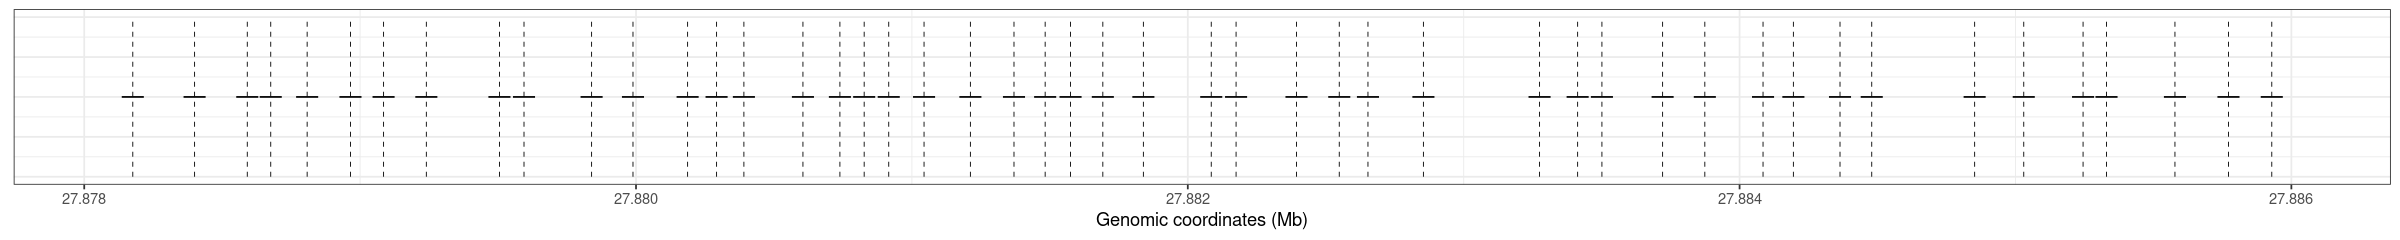

In [24]:
options(repr.plot.width=20, repr.plot.height=2)
ggplot(probe, aes(x=start/1e6, xend=end/1e6, y=1, yend=1)) + geom_segment() +
    theme_bw() + labs(x="Genomic coordinates (Mb)") + theme(axis.text.y=element_blank(), axis.ticks.y=element_blank(), axis.title.y=element_blank()) +
    geom_segment(aes(x=(start+end)/2e6, xend=(start+end)/2e6, y=.9, yend=1.1), linetype="dashed", size=.25)

[1] "Stats for Tm"
[1] "Tm range: 10.681664"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  80.03   81.45   82.63   83.39   84.89   90.71 

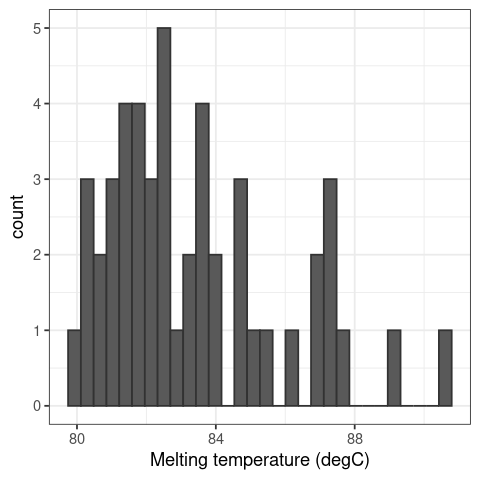

In [25]:
print("Stats for Tm")
print(sprintf("Tm range: %f", probe[, Tm_range[1]]))
probe[, summary(Tm)]
options(repr.plot.width=4, repr.plot.height=4)
ggplot(probe, aes(x=Tm)) + geom_histogram(bins=30, color="#323232") + labs(x="Melting temperature (degC)") + theme_bw()

[1] "Stats for distance between consecutive oligos"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   5.00   31.50   75.00   84.96  126.00  341.00 

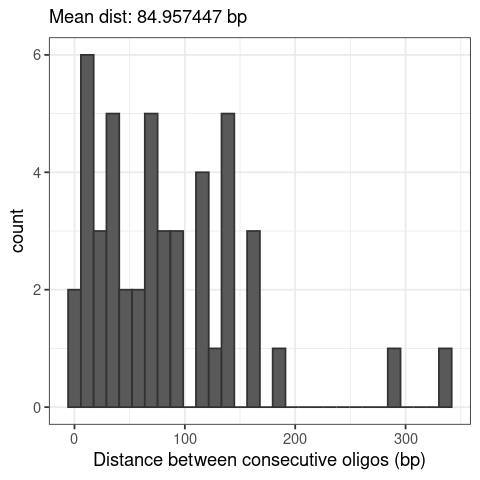

In [26]:
print("Stats for distance between consecutive oligos")
probe[, summary(start[2:.N]-end[1:(.N-1)])]
options(repr.plot.width=4, repr.plot.height=4)
ggplot(probe[, .(odist=start[2:.N]-end[1:(.N-1)])]) + geom_histogram(aes(x=odist), color="#323232", bins=30) +
    labs(x="Distance between consecutive oligos (bp)", subtitle=sprintf("Mean dist: %f bp", probe[, mean(start[2:.N]-end[1:(.N-1)])])) + theme_bw()

In [20]:
print("Stats for off_targets")
probe[, summary(offtargets_no)]
probe[, .N, by=offtargets_no][order(offtargets_no)]

[1] "Stats for off_targets"


ERROR: Error in summary(offtargets_no): object 'offtargets_no' not found
